In [ ]:
!pip install livelossplot tqdm pycm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA version: 12.4


In [ ]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import EdgeConv, GATConv, GlobalAttention
from torch_geometric.loader import DataLoader
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics import r2_score
from IPython.display import display, clear_output
import time

## GNO

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class NormalizeTransform:
    def __init__(self, feature_mean, feature_std, target_mean, target_std):
        self.feature_mean = torch.tensor(feature_mean, dtype=torch.float)
        self.feature_std = torch.tensor(feature_std, dtype=torch.float)
        self.target_mean = torch.tensor(target_mean, dtype=torch.float)
        self.target_std = torch.tensor(target_std, dtype=torch.float)

    def __call__(self, data):
        data.x = (data.x - self.feature_mean) / self.feature_std
        data.y = (data.y - self.target_mean) / self.target_std
        return data

class ReservoirDataset(Dataset):
    def __init__(self, root_dir, target_key='gas_saturation', transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.file_paths = sorted(glob(os.path.join(root_dir, "*.npz")))
        if len(self.file_paths) == 0:
            raise FileNotFoundError(f"No .npz files found in {root_dir}")
        print(f"Found {len(self.file_paths)} data files in {root_dir}")
        self.target_key = target_key
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        data_dict = np.load(path)

        H, W = data_dict['porosity'].shape

        # Create node features
        feature_stack = np.stack([
            data_dict['porosity'],
            data_dict['perm_r'],
            data_dict['perm_z'],
            np.full((H, W), data_dict['inj_rate']),
            np.full((H, W), data_dict['temperature']),
            np.full((H, W), data_dict['depth']),
            np.full((H, W), data_dict['Swi']),
            np.full((H, W), data_dict['lam']),
        ], axis=-1)

        # Add perforation mask
        perf_interval = data_dict['perf_interval']
        perf_mask = np.zeros((H, W))
        perf_mask[perf_interval[0]:perf_interval[1], :] = 1
        feature_stack = np.concatenate([feature_stack, perf_mask[..., None]], axis=-1)

        # Add positional encoding
        i_coords = np.linspace(0, 1, H, dtype=np.float32)
        j_coords = np.linspace(0, 1, W, dtype=np.float32)
        ii, jj = np.meshgrid(i_coords, j_coords, indexing='ij')
        feature_stack = np.concatenate([feature_stack, ii[..., None], jj[..., None]], axis=-1)

        node_features = torch.tensor(feature_stack.reshape(-1, 11), dtype=torch.float)
        labels = torch.tensor(data_dict[self.target_key].reshape(-1, 24), dtype=torch.float)

        edge_index = self.build_edge_index(H, W)
        data = Data(x=node_features, edge_index=edge_index, y=labels)

        if self.transform:
            data = self.transform(data)
        return data

    @staticmethod
    def build_edge_index(height, width):
        edges = []
        for i in range(height):
            for j in range(width):
                idx = i * width + j
                if i > 0: edges.append([idx, (i-1)*width + j])
                if i < height-1: edges.append([idx, (i+1)*width + j])
                if j > 0: edges.append([idx, i*width + (j-1)])
                if j < width-1: edges.append([idx, i*width + (j+1)])
        return torch.tensor(edges, dtype=torch.long).t().contiguous()

class ReservoirGNO(torch.nn.Module):
    def __init__(self, num_features=11, hidden_dim=128, output_steps=24):
        super().__init__()
        self.proj = torch.nn.Linear(num_features, hidden_dim)

        self.conv1 = EdgeConv(
            nn=torch.nn.Sequential(
                torch.nn.Linear(2*hidden_dim, hidden_dim),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
            ), aggr='mean'
        )

        self.conv2 = EdgeConv(
            nn=torch.nn.Sequential(
                torch.nn.Linear(2*hidden_dim, hidden_dim),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
            ), aggr='mean'
        )

        self.conv3 = EdgeConv(
            nn=torch.nn.Sequential(
                torch.nn.Linear(2*hidden_dim, hidden_dim),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
            ), aggr='mean'
        )

        self.fc_out = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_steps)
        )

    def forward(self, x, edge_index):
        x = self.proj(x)
        identity = x

        x = self.conv1(x, edge_index)
        x = F.relu(x) + identity

        identity = x
        x = self.conv2(x, edge_index)
        x = F.relu(x) + identity

        identity = x
        x = self.conv3(x, edge_index)
        x = F.relu(x) + identity

        return self.fc_out(x)


# Function to evaluate the model
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index)
            loss = criterion(preds, batch.y)
            total_loss += loss.item()

            # Collect predictions and targets for R² calculation
            all_preds.append(preds.cpu().numpy())
            all_targets.append(batch.y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate R² score
    r2 = r2_score(all_targets.flatten(), all_preds.flatten())

    return total_loss / len(data_loader), r2

# Live plotting class
class LivePlot:
    def __init__(self, max_epochs):
        self.train_losses = []
        self.val_losses = []
        self.train_r2s = []
        self.val_r2s = []
        self.epochs = []
        self.max_epochs = max_epochs

        # Create figure with two subplots
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(15, 5))
        plt.ion()  # Turn on interactive mode

        # Initialize plots
        self.loss_lines = {
            'train': self.ax1.plot([], [], 'b-', label='Training Loss')[0],
            'val': self.ax1.plot([], [], 'r-', label='Validation Loss')[0]
        }

        self.r2_lines = {
            'train': self.ax2.plot([], [], 'b-', label='Training R²')[0],
            'val': self.ax2.plot([], [], 'r-', label='Validation R²')[0]
        }

        # Set up plot labels and legends
        self.ax1.set_xlabel('Epoch')
        self.ax1.set_ylabel('Loss')
        self.ax1.set_title('Training and Validation Loss')
        self.ax1.legend()
        self.ax1.grid(True)

        self.ax2.set_xlabel('Epoch')
        self.ax2.set_ylabel('R² Score')
        self.ax2.set_title('Training and Validation R² Score')
        self.ax2.legend()
        self.ax2.grid(True)

        # Initialize axes limits
        self.ax1.set_xlim(0, max_epochs)
        self.ax2.set_xlim(0, max_epochs)
        self.ax1.set_ylim(0, 1)  # Will be adjusted as data comes in
        self.ax2.set_ylim(-0.1, 1)  # R² is typically between -∞ and 1

        plt.tight_layout()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

    def update(self, epoch, train_loss, val_loss, train_r2, val_r2):
        # Append new data
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_r2s.append(train_r2)
        self.val_r2s.append(val_r2)

        # Update line data
        self.loss_lines['train'].set_data(self.epochs, self.train_losses)
        self.loss_lines['val'].set_data(self.epochs, self.val_losses)
        self.r2_lines['train'].set_data(self.epochs, self.train_r2s)
        self.r2_lines['val'].set_data(self.epochs, self.val_r2s)

        # Adjust y-axis limits if needed
        if len(self.train_losses) > 1:
            max_loss = max(max(self.train_losses), max(self.val_losses))
            min_loss = min(min(self.train_losses), min(self.val_losses))
            self.ax1.set_ylim(min_loss * 0.9, max_loss * 1.1)

            min_r2 = min(min(self.train_r2s), min(self.val_r2s))
            self.ax2.set_ylim(min(min_r2 * 0.9, -0.1), 1.0)

        # Redraw the figure
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.1)

    def save(self, filename='training_plots.png'):
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plots saved to {filename}")

# Main function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=50, save_path=None, patience=10):
    """
    Trains the model and stops early if validation loss does not improve for patience epochs.
    """
    plotter = LivePlot(num_epochs)
    best_val_loss = float('inf')
    epochs_without_improve = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_targets = []

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch.x, batch.edge_index)
            loss = criterion(preds, batch.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            all_train_preds.append(preds.detach().cpu().numpy())
            all_train_targets.append(batch.y.cpu().numpy())

        all_train_preds = np.concatenate(all_train_preds, axis=0)
        all_train_targets = np.concatenate(all_train_targets, axis=0)
        train_r2 = r2_score(all_train_targets.flatten(), all_train_preds.flatten())

        # Validation phase
        val_loss, val_r2 = evaluate_model(model, val_loader, criterion)
        avg_train_loss = train_loss / len(train_loader)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improve = 0
            # Save best model
            if save_path:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': val_loss,
                    'train_r2': train_r2,
                    'val_r2': val_r2
                }, save_path)
                print(f"Model checkpoint saved to {save_path}")
        else:
            epochs_without_improve += 1
            print(f"No improvement for {epochs_without_improve}/{patience} epochs.")

        # Update live plot and print stats
        plotter.update(epoch + 1, avg_train_loss, val_loss, train_r2, val_r2)
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s - "
              f"Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f} - "
              f"Train R²: {train_r2:.4f} - Val R²: {val_r2:.4f}")

        # Stop if no improvement in patience epochs
        if epochs_without_improve >= patience:
            print(f"Stopping early after {epoch+1} epochs with no improvement.")
            break

    # After training
    plotter.save()
    return model

Using device: cuda


## GAT

In [22]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class NormalizeTransform:
    def __init__(self, feature_mean, feature_std, target_mean, target_std):
        self.feature_mean = torch.tensor(feature_mean, dtype=torch.float)
        self.feature_std = torch.tensor(feature_std, dtype=torch.float)
        self.target_mean = torch.tensor(target_mean, dtype=torch.float)
        self.target_std = torch.tensor(target_std, dtype=torch.float)

    def __call__(self, data):
        data.x = (data.x - self.feature_mean) / self.feature_std
        data.y = (data.y - self.target_mean) / self.target_std
        return data

class ReservoirDataset(Dataset):
    def __init__(self, root_dir, target_key='gas_saturation', transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.file_paths = sorted(glob(os.path.join(root_dir, "*.npz")))
        if len(self.file_paths) == 0:
            raise FileNotFoundError(f"No .npz files found in {root_dir}")
        print(f"Found {len(self.file_paths)} data files in {root_dir}")
        self.target_key = target_key
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        data_dict = np.load(path)

        H, W = data_dict['porosity'].shape

        # Create node features
        feature_stack = np.stack([
            data_dict['porosity'],
            data_dict['perm_r'],
            data_dict['perm_z'],
            np.full((H, W), data_dict['inj_rate']),
            np.full((H, W), data_dict['temperature']),
            np.full((H, W), data_dict['depth']),
            np.full((H, W), data_dict['Swi']),
            np.full((H, W), data_dict['lam']),
        ], axis=-1)

        # Add perforation mask
        perf_interval = data_dict['perf_interval']
        perf_mask = np.zeros((H, W))
        perf_mask[perf_interval[0]:perf_interval[1], :] = 1
        feature_stack = np.concatenate([feature_stack, perf_mask[..., None]], axis=-1)

        # Add positional encoding
        i_coords = np.linspace(0, 1, H, dtype=np.float32)
        j_coords = np.linspace(0, 1, W, dtype=np.float32)
        ii, jj = np.meshgrid(i_coords, j_coords, indexing='ij')
        feature_stack = np.concatenate([feature_stack, ii[..., None], jj[..., None]], axis=-1)

        node_features = torch.tensor(feature_stack.reshape(-1, 11), dtype=torch.float)
        labels = torch.tensor(data_dict[self.target_key].reshape(-1, 24), dtype=torch.float)

        edge_index = self.build_edge_index(H, W)
        data = Data(x=node_features, edge_index=edge_index, y=labels)

        if self.transform:
            data = self.transform(data)
        return data

    @staticmethod
    def build_edge_index(height, width):
        edges = []
        for i in range(height):
            for j in range(width):
                idx = i * width + j
                if i > 0: edges.append([idx, (i-1)*width + j])
                if i < height-1: edges.append([idx, (i+1)*width + j])
                if j > 0: edges.append([idx, i*width + (j-1)])
                if j < width-1: edges.append([idx, i*width + (j+1)])
        return torch.tensor(edges, dtype=torch.long).t().contiguous()

class ReservoirGNO(torch.nn.Module):
    def __init__(self, num_features=11, hidden_dim=128, output_steps=24,
                 gat_heads=4, gat_dropout=0.1):
        super().__init__()
        self.proj = torch.nn.Linear(num_features, hidden_dim)

        self.conv1 = EdgeConv(
            nn=torch.nn.Sequential(
                torch.nn.Linear(2*hidden_dim, hidden_dim),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
            ), aggr='mean'
        )

        self.conv2 = EdgeConv(
            nn=torch.nn.Sequential(
                torch.nn.Linear(2*hidden_dim, hidden_dim),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
            ), aggr='mean'
        )

        self.conv3 = EdgeConv(
            nn=torch.nn.Sequential(
                torch.nn.Linear(2*hidden_dim, hidden_dim),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
            ), aggr='mean'
        )

        def make_edgeconv():
            return EdgeConv(
                nn=torch.nn.Sequential(
                    torch.nn.Linear(2*hidden_dim, hidden_dim),
                    torch.nn.BatchNorm1d(hidden_dim),
                    torch.nn.ReLU(),
                    torch.nn.Linear(hidden_dim, hidden_dim),
                ), aggr='mean'
            )
        self.conv1 = make_edgeconv()
        self.conv2 = make_edgeconv()
        self.conv3 = make_edgeconv()

        # Add a graph-attention layer
        # If concat=True, output dim = heads * hidden_dim, so we project back
        self.gat = GATConv(hidden_dim, hidden_dim, heads=gat_heads,
                           concat=True, dropout=gat_dropout)
        self.gat_lin = torch.nn.Linear(gat_heads * hidden_dim, hidden_dim)

        # Final MLP to output time-series
        self.fc_out = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_steps)
        )

    def forward(self, x, edge_index):
        # initial projection
        x = self.proj(x)

        # three EdgeConv blocks with residuals
        identity = x
        x = self.conv1(x, edge_index)
        x = F.relu(x) + identity

        identity = x
        x = self.conv2(x, edge_index)
        x = F.relu(x) + identity

        identity = x
        x = self.conv3(x, edge_index)
        x = F.relu(x) + identity

        # ** attention **
        # apply GATConv
        gat_out = self.gat(x, edge_index)
        # project back to hidden_dim
        x = F.relu(self.gat_lin(gat_out)) + x

        # final readout
        return self.fc_out(x)


# Function to evaluate the model
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index)
            loss = criterion(preds, batch.y)
            total_loss += loss.item()

            # Collect predictions and targets for R² calculation
            all_preds.append(preds.cpu().numpy())
            all_targets.append(batch.y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate R² score
    r2 = r2_score(all_targets.flatten(), all_preds.flatten())

    return total_loss / len(data_loader), r2

# Live plotting class
class LivePlot:
    def __init__(self, max_epochs):
        self.train_losses = []
        self.val_losses = []
        self.train_r2s = []
        self.val_r2s = []
        self.epochs = []
        self.max_epochs = max_epochs

        # Create figure with two subplots
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(15, 5))
        plt.ion()  # Turn on interactive mode

        # Initialize plots
        self.loss_lines = {
            'train': self.ax1.plot([], [], 'b-', label='Training Loss')[0],
            'val': self.ax1.plot([], [], 'r-', label='Validation Loss')[0]
        }

        self.r2_lines = {
            'train': self.ax2.plot([], [], 'b-', label='Training R²')[0],
            'val': self.ax2.plot([], [], 'r-', label='Validation R²')[0]
        }

        # Set up plot labels and legends
        self.ax1.set_xlabel('Epoch')
        self.ax1.set_ylabel('Loss')
        self.ax1.set_title('Training and Validation Loss')
        self.ax1.legend()
        self.ax1.grid(True)

        self.ax2.set_xlabel('Epoch')
        self.ax2.set_ylabel('R² Score')
        self.ax2.set_title('Training and Validation R² Score')
        self.ax2.legend()
        self.ax2.grid(True)

        # Initialize axes limits
        self.ax1.set_xlim(0, max_epochs)
        self.ax2.set_xlim(0, max_epochs)
        self.ax1.set_ylim(0, 1)  # Will be adjusted as data comes in
        self.ax2.set_ylim(-0.1, 1)  # R² is typically between -∞ and 1

        plt.tight_layout()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

    def update(self, epoch, train_loss, val_loss, train_r2, val_r2):
        # Append new data
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_r2s.append(train_r2)
        self.val_r2s.append(val_r2)

        # Update line data
        self.loss_lines['train'].set_data(self.epochs, self.train_losses)
        self.loss_lines['val'].set_data(self.epochs, self.val_losses)
        self.r2_lines['train'].set_data(self.epochs, self.train_r2s)
        self.r2_lines['val'].set_data(self.epochs, self.val_r2s)

        # Adjust y-axis limits if needed
        if len(self.train_losses) > 1:
            max_loss = max(max(self.train_losses), max(self.val_losses))
            min_loss = min(min(self.train_losses), min(self.val_losses))
            self.ax1.set_ylim(min_loss * 0.9, max_loss * 1.1)

            min_r2 = min(min(self.train_r2s), min(self.val_r2s))
            self.ax2.set_ylim(min(min_r2 * 0.9, -0.1), 1.0)

        # Redraw the figure
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.1)

    def save(self, filename='training_plots.png'):
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plots saved to {filename}")

# Main function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=50, save_path=None, patience=10):
    """
    Trains the model and stops early if validation loss does not improve for `patience` epochs.
    """
    plotter = LivePlot(num_epochs)
    best_val_loss = float('inf')
    epochs_without_improve = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_targets = []

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch.x, batch.edge_index)
            loss = criterion(preds, batch.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            all_train_preds.append(preds.detach().cpu().numpy())
            all_train_targets.append(batch.y.cpu().numpy())

        all_train_preds = np.concatenate(all_train_preds, axis=0)
        all_train_targets = np.concatenate(all_train_targets, axis=0)
        train_r2 = r2_score(all_train_targets.flatten(), all_train_preds.flatten())

        # Validation phase
        val_loss, val_r2 = evaluate_model(model, val_loader, criterion)
        avg_train_loss = train_loss / len(train_loader)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improve = 0
            # Save best model
            if save_path:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': val_loss,
                    'train_r2': train_r2,
                    'val_r2': val_r2
                }, save_path)
                print(f"Model checkpoint saved to {save_path}")
        else:
            epochs_without_improve += 1
            print(f"No improvement for {epochs_without_improve}/{patience} epochs.")

        # Update live plot and print stats
        plotter.update(epoch + 1, avg_train_loss, val_loss, train_r2, val_r2)
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s - "
              f"Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f} - "
              f"Train R²: {train_r2:.4f} - Val R²: {val_r2:.4f}")

        # Stop if no improvement in `patience` epochs
        if epochs_without_improve >= patience:
            print(f"Stopping early after {epoch+1} epochs with no improvement.")
            break

    # After training
    plotter.save()
    return model

Using device: cuda


# TRAIN n Results

In [23]:
if __name__ == "__main__":
    try:
        torch.manual_seed(42)
        np.random.seed(42)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(42)

        batch_size = 8
        learning_rate = 0.001
        weight_decay = 1e-5
        num_epochs = 100
        val_ratio = 0.2

        print("Loading datasets...")
        full_dataset = ReservoirDataset("./train_data", target_key='pressure_buildup')

        # Split dataset
        dataset_size = len(full_dataset)
        val_size = int(val_ratio * dataset_size)
        train_size = dataset_size - val_size
        train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

        # Compute normalization stats from training data
        all_features = []
        all_targets = []
        for idx in train_dataset.indices:
            data = full_dataset[idx]
            all_features.append(data.x.numpy())
            all_targets.append(data.y.numpy())

        all_features = np.concatenate(all_features, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        feature_mean = all_features.mean(axis=0)
        feature_std = all_features.std(axis=0)
        target_mean = all_targets.mean(axis=0)
        target_std = all_targets.std(axis=0)

        feature_std[feature_std == 0] = 1.0
        target_std[target_std == 0] = 1.0

        # Apply normalization transform to the full dataset
        normalize_transform = NormalizeTransform(feature_mean, feature_std, target_mean, target_std)
        full_dataset.transform = normalize_transform

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # model = ReservoirGNO().to(device)
        # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # criterion = torch.nn.MSELoss()

        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        # optimizer, mode='min', factor=0.5, patience=5, verbose=True)

        # print("Starting training with early stopping...")
        # model = train_model(
        # model, train_loader, val_loader, criterion, optimizer,
        # num_epochs=num_epochs, save_path="best_pressure_gno.pt", patience=10
        # )

        # print("Training completed!")

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

Loading datasets...
Found 3499 data files in ./train_data


Found 501 data files in ./val_set
Data(x=[7600, 11], edge_index=[2, 29924], y=[7600, 24])


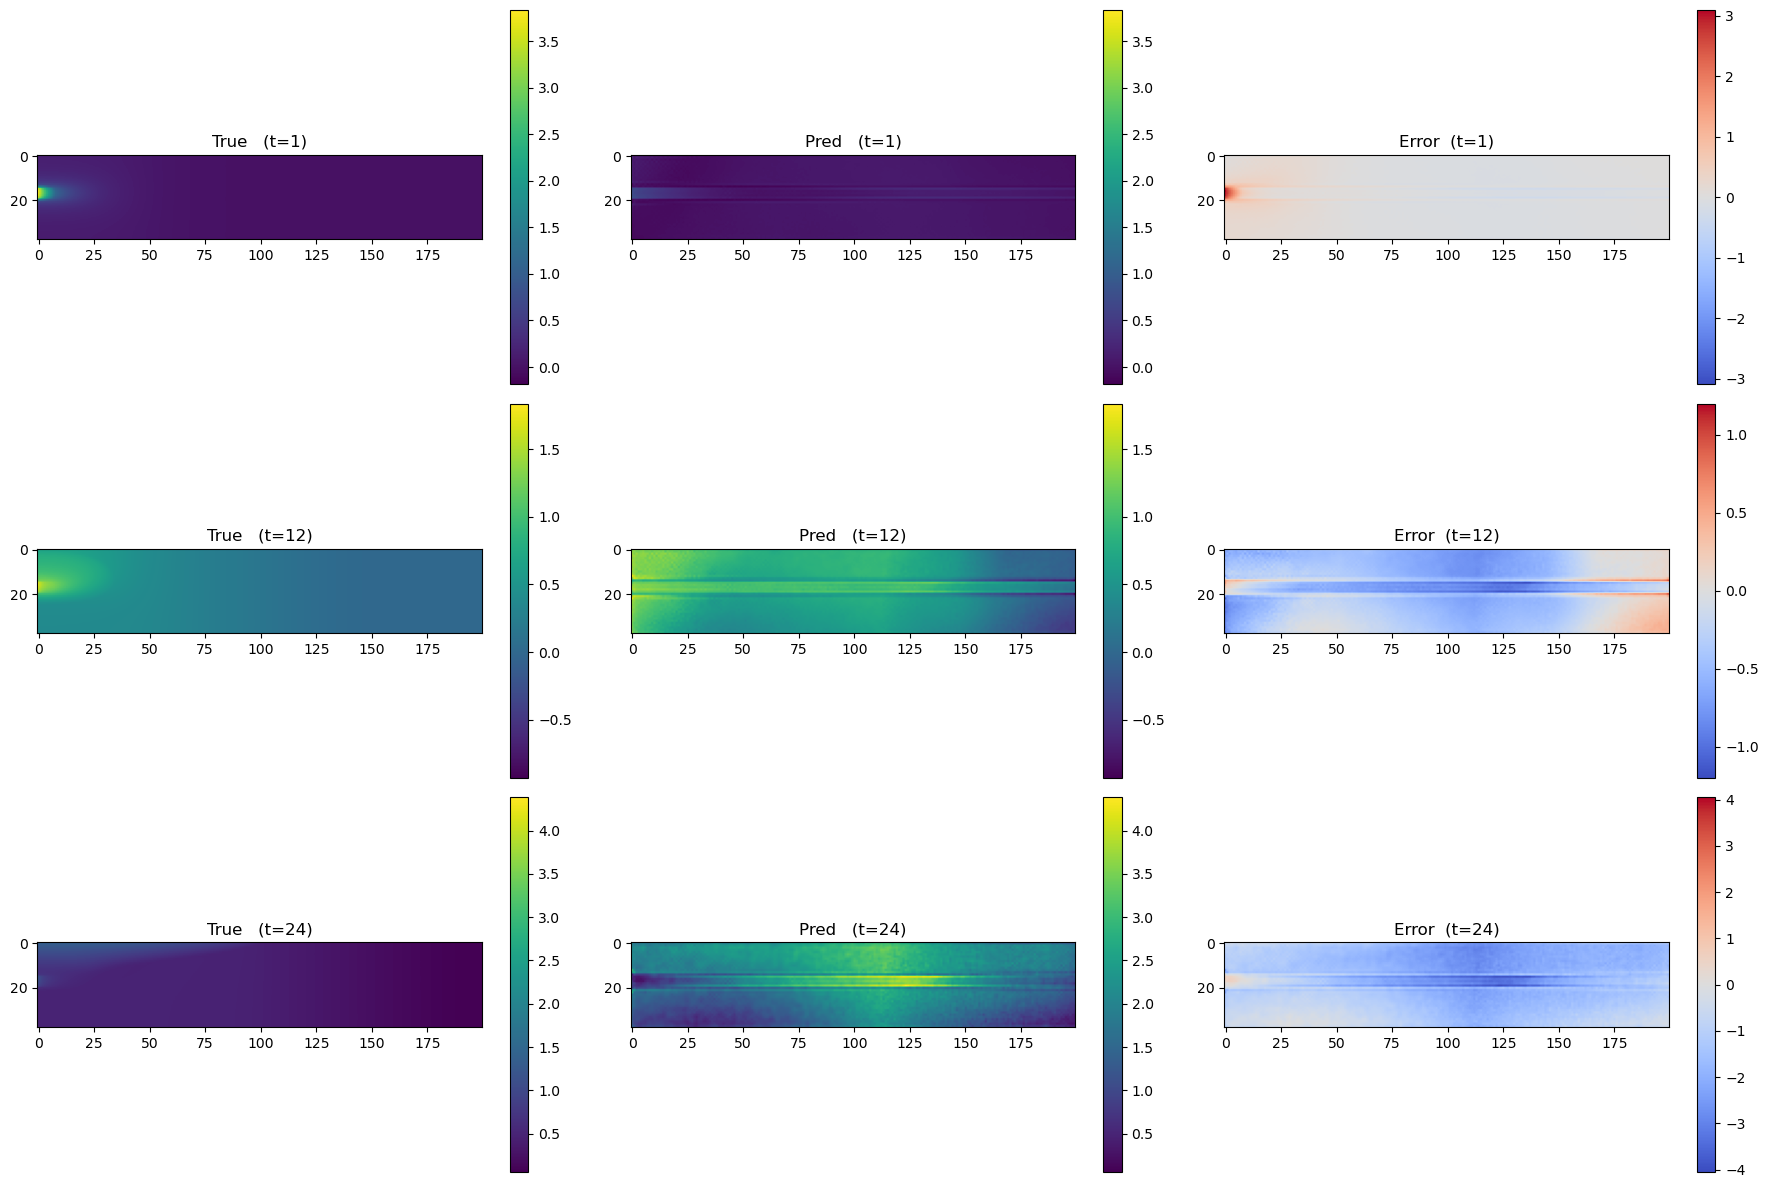

In [28]:
# Get one sample from dataset (WITH NORMALIZATION)
# Make sure these variables are available from your training code:
# target_mean, target_std (numpy arrays)
dataset = ReservoirDataset("./val_set",
                         target_key='pressure_buildup',
                         transform=NormalizeTransform(feature_mean, feature_std, target_mean, target_std))

# sample = dataset[5]
# sample = sample.to(device)

sample_idx = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReservoirGNO().to(device)  # Replace with your actual model class
state_dict = torch.load("best_pressure_gat.pt", map_location=device, weights_only=False)
model.load_state_dict(state_dict["model_state_dict"]) # If you have saved weights
model.eval()

data = dataset[sample_idx].to(device)

print(dataset[sample_idx])
with torch.no_grad():
    pred_norm = model(data.x, data.edge_index).cpu().numpy()
true_norm   = data.y.cpu().numpy()

# 3) denormalize
pred = pred_norm * target_std + target_mean
true = true_norm * target_std + target_mean

# 4) recover H,W from the original .npz porosity array
path = dataset.file_paths[sample_idx]
por = np.load(path)['porosity']
H, W = por.shape

# 5) plot
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
timesteps = [0, 11, 23]

for row, t in enumerate(timesteps):
    p_t   = pred[:, t].reshape(H, W)
    t_t   = true[:, t].reshape(H, W)
    err_t = t_t - p_t

    # pick shared vmin/vmax for truth & pred
    vmin = float(min(p_t.min(), t_t.min()))
    vmax = float(max(p_t.max(), t_t.max()))

    # Truth
    im0 = axs[row, 0].imshow(t_t, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[row, 0].set_title(f"True   (t={t+1})")
    fig.colorbar(im0, ax=axs[row, 0])

    # Prediction
    im1 = axs[row, 1].imshow(p_t, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[row, 1].set_title(f"Pred   (t={t+1})")
    fig.colorbar(im1, ax=axs[row, 1])

    # Error
    lim = float(np.max(np.abs(err_t)))
    im2 = axs[row, 2].imshow(err_t, cmap='coolwarm', vmin=-lim, vmax=lim)
    axs[row, 2].set_title(f"Error  (t={t+1})")
    fig.colorbar(im2, ax=axs[row, 2])

plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from torch_geometric.loader import DataLoader

# Assuming you have these defined from previous code
# from dataset import ReservoirDataset
# from transforms import NormalizeTransform

def evaluate_model(model, dataset_path, target_mean, target_std, batch_size=32):
    # Load dataset
    dataset = ReservoirDataset(
        dataset_path,
        target_key='pressure_buildup',
        transform=NormalizeTransform(feature_mean, feature_std, target_mean, target_std)
    )

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_preds = []
    all_trues = []

    model.eval()
    with torch.no_grad():
        for sample in loader:
            sample = sample.to(device)
            pred = model(sample.x, sample.edge_index)

            # Denormalize
            pred_denorm = pred.cpu().numpy() * target_std + target_mean
            true_denorm = sample.y.cpu().numpy() * target_std + target_mean

            all_preds.append(pred_denorm)
            all_trues.append(true_denorm)

    # Concatenate all results
    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)

    # Calculate metrics
    mse = mean_squared_error(all_trues.flatten(), all_preds.flatten())
    r2 = r2_score(all_trues.flatten(), all_preds.flatten())

    return mse, r2

# Usage

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReservoirGNO().to(device)  # Replace with your actual model class
state_dict = torch.load("best_pressure_gat.pt", map_location=device, weights_only=False)
model.load_state_dict(state_dict["model_state_dict"]) # If you have saved weights

mse, r2 = evaluate_model(
    model=model,
    dataset_path="./val_set",
    target_mean=target_mean,  # Your target normalization parameters
    target_std=target_std     # Should match training normalization
)

print(f"Validation Metrics:")
print(f"MSE: {mse:.4e}")
print(f"R²: {r2:.4f}")

Found 501 data files in ./val_set
Validation Metrics:
MSE: 7.9990e+01
R²: 0.8694
